In [15]:
!cp *.png ../notes/Blog/"Sampling from Any Distribution Part 2"
!cp *.gif ../notes/Blog/"Sampling from Any Distribution Part 2"

In [4]:
import os

import matplotlib.pyplot as plt
import imageio
from tqdm import tqdm
import numpy as np

from sampling.linear_samplers import TriangleSampler, create_segment_sampler, piecewise_linear_sampler

plt.style.use('seaborn-v0_8-darkgrid')

In [5]:
def visualize_sampler(sampler, num_samples=100_000, num_bins=100, fname=None):
    # Generating points for the line plot of f
    x_range = np.linspace(*sampler.domain, 500)
    y_values = [sampler.f(x) for x in x_range]

    # Generating samples
    samples = [sampler.draw() for _ in range(num_samples)]

    # Creating subplots
    fig, axs = plt.subplots(2, 1, figsize=(10, 8))

    # Plotting the piecewise linear function
    axs[0].plot(x_range, y_values, label="f(x)")
    axs[0].set_title("Function")
    axs[0].set_ylim(0, max(y_values))
    axs[0].legend()

    # Plotting the histogram of samples
    axs[1].hist(samples, bins=num_bins, density=True, alpha=0.7, label="Sampled Distribution")
    axs[1].set_title("Histogram of Samples")
    axs[1].legend()

    plt.tight_layout()
    plt.show()
    if fname:
        fig.savefig(fname)

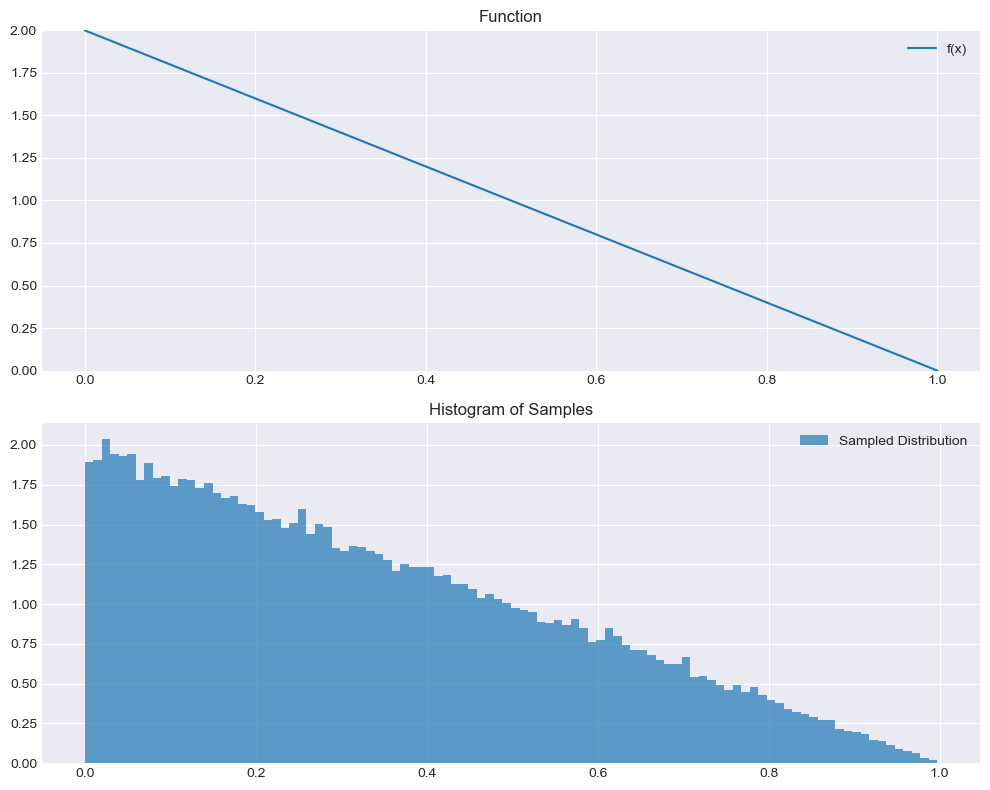

In [6]:
sampler = TriangleSampler(0, 2, 1, 0)
visualize_sampler(sampler, fname="triangle.png")

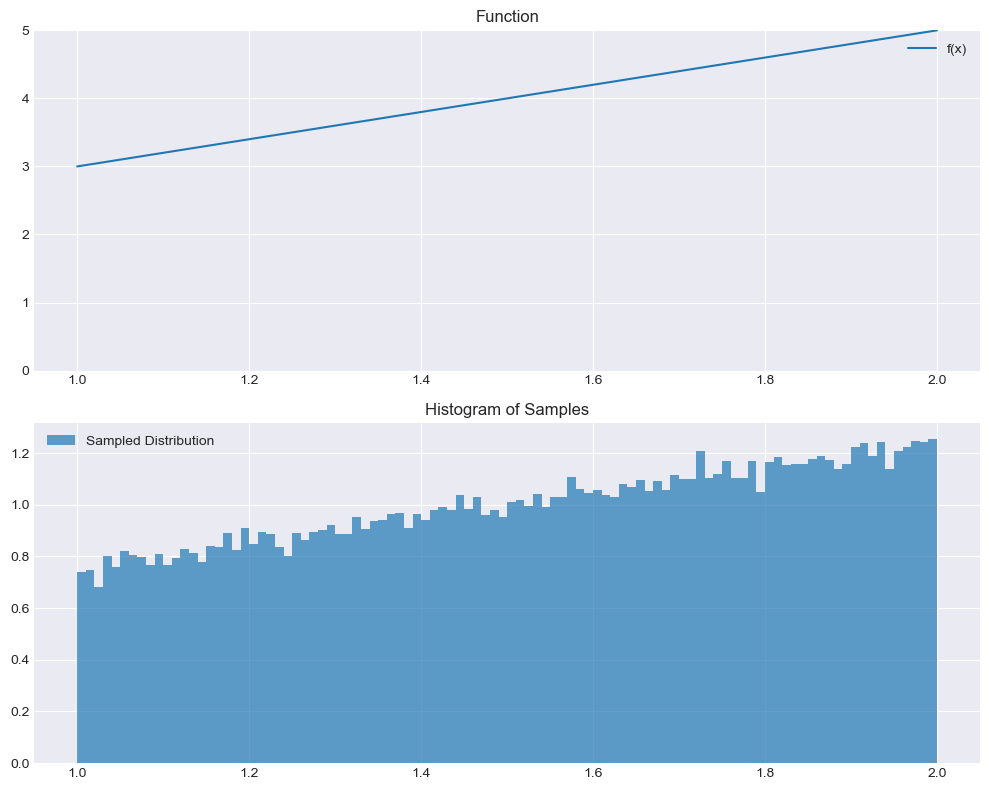

In [7]:
sampler = create_segment_sampler((1, 3), (2, 5))
visualize_sampler(sampler, fname="trapezium.png")

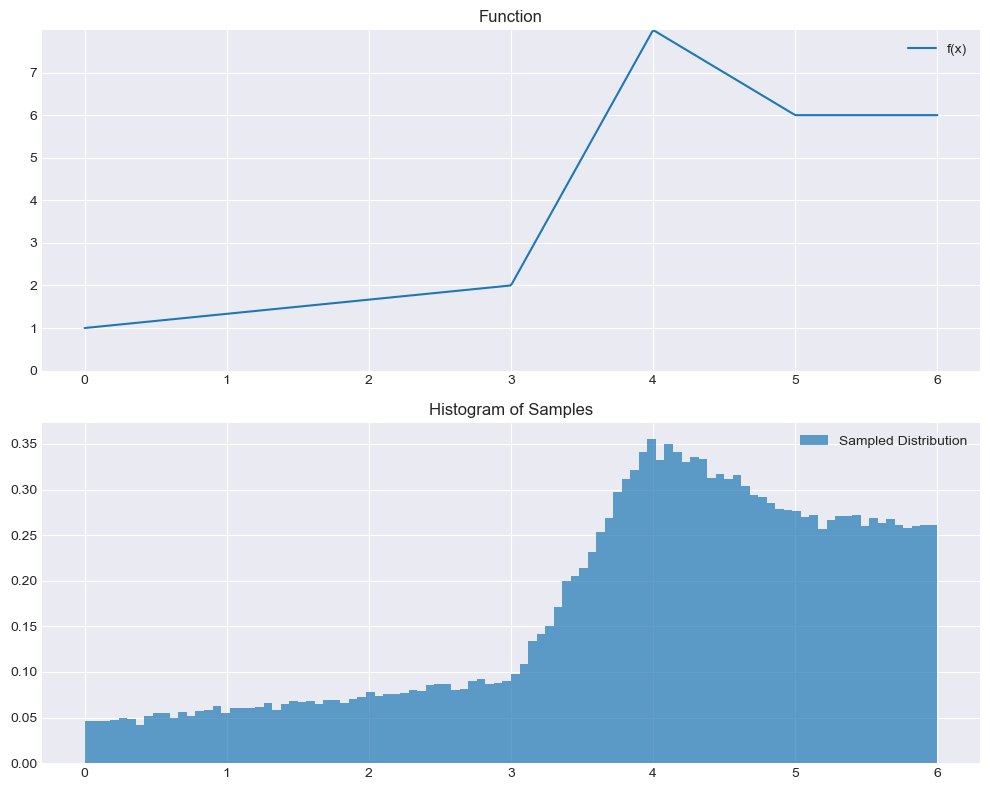

In [8]:
sampler = piecewise_linear_sampler([
    (0, 1),
    (3, 2),
    (4, 8),
    (5, 6),
    (6, 6),
])
visualize_sampler(sampler, fname="piecewise_linear.png")

In [14]:
from scipy.stats import norm

def gaussian_pdf(x):
    return norm.pdf(x, 0, 1)

def sample_point(sampler) -> tuple[float, float]:
    x = sampler.draw()
    y = np.random.uniform(0, sampler.f(x))

    return x, y

n_frames = 100
x_min, x_max = -10, 10
x = np.linspace(x_min, x_max, 400)
pdf_y = gaussian_pdf(x)

y_max = gaussian_pdf(0) 
env_sampler = create_segment_sampler((x_min, y_max), (x_max, y_max))

gif_filepath = 'rejection_sampling_with_bars.gif'

points = []
accepted_count = 0
rejected_count = 0

filenames = []
for frame in tqdm(range(n_frames), desc="Generating frames"):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw={'width_ratios': [3, 1]})

    # Main plot
    ax1.plot(x, pdf_y, label="PDF", color='blue')
    ax1.fill_between(x, pdf_y, alpha=0.2, color='blue')
    ax1.plot(x, [env_sampler.f(x_) for x_ in x], label="Envelope", color="orange")

    new_x, new_y = sample_point(env_sampler)
    points.append((new_x, new_y, new_y < gaussian_pdf(new_x)))

    # Update counters
    accepted_count += new_y < gaussian_pdf(new_x)
    rejected_count += new_y >= gaussian_pdf(new_x)

    # Scatter plot
    for px, py, accepted in points:
        color = 'green' if accepted else 'red'
        ax1.scatter(px, py, color=color, marker='x')

    # Bar plot for counts
    ax2.bar(['Accepted', 'Rejected'], [accepted_count, rejected_count], color=['green', 'red'])
    ax2.set_title('Points Count')
    ax2.set_ylim(0, n_frames)

    filename = f'frame_{frame}.png'
    plt.savefig(filename, dpi=150)
    filenames.append(filename)
    plt.close()

with imageio.get_writer(gif_filepath, mode='I', fps=20, loop=0) as writer:
    for filename in tqdm(filenames, desc="Compiling GIF"):
        image = imageio.imread(filename)
        writer.append_data(image)

for filename in filenames:
    os.remove(filename)

Compiling GIF:   0%|                                                                                                                                            | 0/100 [00:00<?, ?it/s]/var/folders/pg/yftfgy0j309dq_sv_0j5q_l80000gp/T/ipykernel_23693/2802416111.py:74: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
Compiling GIF: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 52.72it/s]
